# Patterns and Trends in Billboard Weekly #1 Hits
### Candidate Number: 20751

We are interested in what patterns and trends exist in the Weekly Billboard Number 1 hits.  Once an artist or song tops the charts, how long are they likely to spend up there?  Which genres are the most popular, and most likely to reach number 1?  Are bands or solo artists more likely to top the charts?  Does the age of an artist matter?  Do artists from particular regions tend to reach number 1 more often?  How have all these trends changed over time?  These are some of the questions which we will be focusing on.  

## 1. Set-up and Obtaining the Data

To delve into these questions, we will analyze Billboard's Weekly Number 1 hits, which has been going since 1958.  To get the data, we will webscrape Wikipedia to obtain the list of number 1 hits, as well as data on each song and artist.  (The code was timed to make sure it stays under their hits per second limit.)  In addition, we will use two geocoding API's (Open Street Map and Data Science Toolkit) to get the latitude and longitude coordinates for the origin regions of each artist so we can map it.  The code for obtaining the data is separated into 4 functions (section 1.B.): one for the number 1 hits chart itself which is split into a page for each decade, one for the information for each artist page, one for the information from each song page, and one to get the geographical coordinates.  Then for-loops are used to implement the functions and do the actual webscraping, and then they store the data in a variety of Dataframes (section 1.C).  

### A. Importing all the required libraries

In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from time import time
import json
import matplotlib.pyplot as plt
import datetime as dt
import cartopy.crs as ccrs
import pandas as pd
from sklearn import linear_model
import statsmodels.formula.api as smf
import networkx as nx

### B. Functions for webscrabing and API's
#### i. Song for retrieving the Billboard #1 Weekly Chart
This function takes in the year which starts each time period of Billboard #1 hits pages (usually the start of a decade, with the exception of the first period which contains 1958 through 1969), and then parses the page to obtain the necessary data, turning it into multiple dataframes.  

In [2]:
def getSongList(decade):

    #Creates link based on year provided
    if decade == 1958: #The link of 1958-1960 has a different pattern than the others because more than a decade
        yearlink = "https://en.wikipedia.org/wiki/List_of_Billboard_Hot_100_number-one_singles_from_1958_to_1969"
    else:
        yearlink = "https://en.wikipedia.org/wiki/List_of_Billboard_Hot_100_number-one_singles_of_the_" + str(decade) + "s"

    #Gets data from link, and obtains the table on the page from it 
    page=requests.get(yearlink)
    soup=BeautifulSoup(page.content,'html.parser')
    allTable=soup.find_all('table')[2]
    fullrows = allTable.find_all('tr')

    #Creates blank data frames to store the information
    ChartData = pd.DataFrame()
    AllArtistInfo = pd.DataFrame()
    AllSongInfo = pd.DataFrame()
    MultipleArtistSongs = pd.DataFrame()
    MultipleSongDates = pd.DataFrame()


    #The actual data scraping is in the for-loop, going through the table line by line
    #row 0 is column names, which I am setting myself
    for i in range(1, len(fullrows)):
        rowdata = []
        rowcells = fullrows[i].find_all('td') #Each cell within each row

        if len(rowcells) > 2 : #Eliminates the section headers
            if len(rowcells) == 7: #Accounts for the fact that some pages have a column for Record label, but others don't
                myrange = list(range(0,4))
                myrange.append(5)
            else : 
                myrange = range(0,5)
            for j in myrange:
                if j == 2: #Artist Information and links
                    
                    #Gets text for all artist links, and records name of Artist from that
                    #Since some pages only have links the first time a name appears, but all artists have at least one,
                    #this creates a record of all artists on the page so far
                    TempArtistLinks = rowcells[j].find_all('a') 
                    for k in TempArtistLinks : 
                        if str(k).find("/wiki/") >= 0:
                            SingleArtName = k.text.rstrip()
                            SingleArtLink = k['href']
                            AllArtistInfo = AllArtistInfo.append([[SingleArtName, SingleArtLink]])
                    AllArtistInfo = AllArtistInfo.drop_duplicates(0)

                    tempvalue = rowcells[j].text.rstrip()
    

                    #Since there's no way to tell if A & B is two artists or one band just from looking, 
                    #search the list created above of all artists so far on the page
                    tempArtists = [] 
                    for l in AllArtistInfo.iloc[:,0] : 
                        if tempvalue.find(l) >= 0 :
                            tempArtists.append(l)

                    if len(tempArtists) == 1 : #If only one artist, add it
                        rowdata.append(tempArtists[0])
                    else :
                        rowdata.append("Multiple") #Records that there were multiple artists so they can be looked for later

                elif j == 3: #Song and song links
                    
                    TempSongLinks = rowcells[j].find_all('a')
                    TempAllSongs = []
                    TempMultiSongs = []

                    #Creates record of all songs, and list of ones for this entry
                    for m in range(0,len(TempSongLinks)) : 
                        SingleSongName = TempSongLinks[m].text.rstrip()
                        SingleSongLink = TempSongLinks[m]['href']
                        if SingleSongLink.find("/wiki/") >= 0 :
                            TempAllSongs.append([SingleSongName, SingleSongLink])
                            TempMultiSongs.append([rowdata[0], rowdata[1], SingleSongName])
                    AllSongInfo = AllSongInfo.append(TempAllSongs) 

                    if len(TempMultiSongs) == 1: #If only one song, add it
                        rowdata.append(TempMultiSongs[0][2]) 
                        
                    else: #Stores information when multiple songs in different dataframe
                        MultipleSongDates = MultipleSongDates.append(TempMultiSongs) 
                        rowdata.append("Multiple") #Records that there were multiple artists so they can be looked for later

                    if len(tempArtists) > 1 : #Stores information when multiple artists in different dataframe
                        for n in range(0,len(tempArtists)):
                            tempArtists[n] = [TempMultiSongs[0][0], TempMultiSongs[0][2], tempArtists[n]]
                        MultipleArtistSongs = MultipleArtistSongs.append(tempArtists)

                else:
                    rowdata.append(rowcells[j].text.rstrip()) #Adds this cell to the whole row


            ChartData = ChartData.append([rowdata]) #Adds this row to the dataframe


    
    return ChartData, AllArtistInfo, AllSongInfo, MultipleArtistSongs, MultipleSongDates #Returns all dataframes



#### ii. Function for retrieving information about each song
This function parses the song page for the given song, and gets the required data from it.  

In [3]:
def getSongInfo(songTitle, songWikiLink):
    
    #Gets data from page
    link = "https://en.wikipedia.org" + songWikiLink
    page=requests.get(link)
    soup=BeautifulSoup(page.content,'html.parser')
    
    #Gets the table from the page, and each row
    allTables=soup.find_all('table')
    if str(allTables[0]).find("needs additional citations") >= 0 :
        myTable = allTables[1]
    else:
        myTable = allTables[0]
    fullrows = myTable.find_all('tr')

    #Creates dataframes to store the data
    tempGenres = pd.DataFrame()
    tempLabels = pd.DataFrame()
    
    for i in fullrows: #Goes through each row
        
        if str(i).find("Label") >= 0: #Gets the record label and link
            temp = i.find_all('a')
            for j in range(0,len(temp)):
                tempdata = []
                if j > 0 :
                    if str(temp[j]).find("cite") < 0 :
                        tempdata.append([songTitle, temp[j].text])
                        tempLabels = tempLabels.append(tempdata) #Adds the row to the dataframe
                        
        if str(i).find("Genre") >= 0: #Gets the genre and link
            temp = i.find_all('a')
            for j in range(0,len(temp)):
                tempdata = []
                if j > 0:
                    if str(temp[j]).find("cite") < 0 :
                        tempdata.append([songTitle, temp[j].text])
                        tempGenres = tempGenres.append(tempdata) #Adds the row to the dataframe
                        
    return tempGenres, tempLabels #Returns the data


#### iii. Function for retrieving information about each artist
This function parses the artist page for the given artist link, and gets the required data from it.  

In [4]:
def getArtistInfo(ArtistWikiLink):
    #Gets the data from the page
    link = "https://en.wikipedia.org" + ArtistWikiLink
    page=requests.get(link)
    soup=BeautifulSoup(page.content,'html.parser')

    #Finds the correct table on the page - some don't have one 
    myTable = []
    allTables=soup.find_all('table')
    for i in allTables:
        if str(i).find("infobox ") >= 0 or str(i).find("Background ") >= 0:
            myTable = i
            break

    #Parses the page
    ThisArtistInfo = []
    if len(myTable) != 0:

        fullrows = myTable.find_all('tr') #All the rows

        tempInfo = []
        BandBoolean = True #Default is set that the artist is a band 
        
        #Goes through the rows, if there's a line with "Born", it's a solo artist, otherwise it's stays a band
        for i in fullrows: 
            if i.text.find("Born") >= 0 :
                BandBoolean = False

        #If it's a solo artist, gets the birthday and birthlocation using regular expressions
        if not BandBoolean :
            for i in fullrows:
                if i.text.find("Born") >= 0 :
                    temp = i.text.split("Born")[1]
                    BirthDate = re.findall("\d\d\d\d-\d\d-\d\d", temp)
                    if len(BirthDate) > 0:
                        BirthDate = BirthDate[0]
                    else:
                        BirthDate = np.nan
                    BirthLoc = re.split(" \d\d\d\d", temp)[-1]
                    BirthLoc = BirthLoc.split(")")[-1]
                    BirthLoc = re.sub("\[\d+\]","",BirthLoc)
            ThisArtistInfo = [BandBoolean, BirthLoc, BirthDate]

        #If it's a band, get's its origin location
        else : 
            BandOrigin = np.nan
            for i in fullrows:
                if i.text.find("Origin") >= 0 :
                    BandOrigin = i.text.split('Origin')[1]
                    BandOrigin = re.sub("\[\d+\]","",BandOrigin)
            if BandOrigin == "" :
                BandOrigin = np.nan
            ThisArtistInfo = [BandBoolean, BandOrigin]

    return ThisArtistInfo #Returns the info - might be empty if no info

#### iv. Function for geocoding each location
For each location, this function uses Open Street Map to geocode it.  If that fails, then it uses Data Science Toolkit.  If that fails, it returns an empty result.  

In [8]:
def getLatLon(Address):
    
    #Gets json results of the API query
    temp = re.sub(" ", "+", Address)
    temp = re.sub(",", "%2C", temp)
    link = "https://nominatim.openstreetmap.org/search.php?q=" + temp + "&format=json"
    page=requests.get(link)
    parsedjson = json.loads(page.content)
    
    if parsedjson == [] : #If OSM fails, then we try again with DSTK
        link = "http://www.datasciencetoolkit.org/maps/api/geocode/json?sensor=false&address=" + temp 
        page=requests.get(link)
        parsedjson = json.loads(page.content)
        if parsedjson['results'] == []: #If DSTK fails, we return Null values
            lat = np.nan
            lng = np.nan
        else : #Saves the DSTK results
            lng = parsedjson['results'][0]['geometry']['location']['lng'] 
            lat = parsedjson['results'][0]['geometry']['location']['lat'] 
    else: #Saves the OSM results
        lat = parsedjson[0]['lat']
        lng = parsedjson[0]['lon']
        
    latlon = [lat, lng]
    return latlon #Returns the latitude and longitude 

    

### C. Implementing each function to create my datasets
Now we use the functions above in forloops to webscrape the data and then clean it up.  
#### i. Data from Billboard Charts
First we will get the Billboard Chart information for each of the 6 periods.  

In [9]:
#Starting years of each period
years = [1958, 1970, 1980, 1990, 2000, 2010] 

for i in years:
    
    #Runs the function
    tempdf_Chart, tempdf_Artists, tempdf_Songs, tempdf_MultArtists, tempdf_MultSongs = getSongList(i)
    
    if i == 1958 : #If first period, creates new dataframes
        ChartData, ArtistInfo, SongLinks, MultipleArtistSongs, MultipleSongDates = tempdf_Chart, tempdf_Artists, tempdf_Songs, tempdf_MultArtists, tempdf_MultSongs
    
    else : #If not first period, appends the information to the dataframes that already exist
        ChartData = ChartData.append(tempdf_Chart)
        ArtistInfo = ArtistInfo.append(tempdf_Artists)
        SongLinks = SongLinks.append(tempdf_Songs)
        MultipleArtistSongs = MultipleArtistSongs.append(tempdf_MultArtists)
        MultipleSongDates = MultipleSongDates.append(tempdf_MultSongs)

#Sets the column names 
ChartData.columns = ["#", "DateReachedTop", "Artist", "Song", "WeeksAtTop"]
ArtistInfo.columns = ["Artist", "ArtistLink"]
SongLinks.columns = ["SongName", "SongLink"]
MultipleArtistSongs.columns = ["#", "Song", "Artist"]
MultipleSongDates.columns = ["#", "Date", "Song"] 

#Does some data formatting and clean-up
ChartData['DateReachedTop'] = pd.to_datetime(ChartData['DateReachedTop'], format = "%B %d, %Y")
ChartData["WeeksAtTop"] = pd.to_numeric(ChartData["WeeksAtTop"], errors='coerce')
ArtistInfo = ArtistInfo.drop_duplicates()
SongLinks = SongLinks.drop_duplicates()

#### ii. Data from each song page
Now we will get the information for each song based on the songs and their links retrieved and saved in SongLinks in section 1.C.i.  

In [10]:
#Creates blank dataframes for the data
SongGenres = pd.DataFrame()
SongLabels = pd.DataFrame()

#SongLinks was created above, now use each of those links to get the wikipedia page, and parse it for the data
for i in range(0, SongLinks.shape[0]):
    
    #Runs the function
    tempTitle = SongLinks.iloc[i,0]
    tempLink = SongLinks.iloc[i,1]
    tempGenres, tempLabels = getSongInfo(tempTitle, tempLink)
    
    if i == 0 : #If first time, sets dataframes equal to the results
        SongGenres, SongLabels = tempGenres, tempLabels
        
    else : #Otherwise, appends the results
        SongGenres = SongGenres.append(tempGenres)
        SongLabels = SongLabels.append(tempLabels)


#Sets the column names
SongGenres.columns = ["SongName", "Genre"]
SongLabels.columns = ["SongName", "Label"]

#Formats data
SongGenres["Genre"] = SongGenres["Genre"].str.lower()

#### iii. Data for each artist (from each Wikipedia page, and from Geocoding)
Now we will run both functions related to the artist information in a for-loop based on the artists and their links saved in ArtistInfo in 1.C.i.

In [11]:
#Creates Null columns for each new variable 
ArtistInfo["Band"] = np.nan
ArtistInfo["Birth/Origin_Loc"] = np.nan
ArtistInfo["Birthdate"] = np.nan
ArtistInfo["Lat"] = np.nan
ArtistInfo["Lon"] = np.nan

#ArtistInfo was created above, now use each of those links to get the wikipedia page, and parse it for the data
for i in range(0, ArtistInfo.shape[0]):
    
    #Runs the function
    TempArtistLink = ArtistInfo.iloc[i,1]
    tempInfo = getArtistInfo(TempArtistLink)
    
    if len(tempInfo) > 0 : #If it's not returning an empty list
        ArtistInfo.iloc[i,2] = tempInfo[0] #Band Boolean
        ArtistInfo.iloc[i,3] = tempInfo[1] #Location
        
        if not tempInfo[0] : #If it's a solo artist...
            ArtistInfo.iloc[i,4] = tempInfo[2] #Birthdate
            
        if not pd.isnull(tempInfo[1]): #If the location was not null, then geocode it
            tempLoc = getLatLon(tempInfo[1])
            ArtistInfo.iloc[i,5] = tempLoc[0]
            ArtistInfo.iloc[i,6] = tempLoc[1]

#Formats the date
ArtistInfo['Birthdate'] = pd.to_datetime(ArtistInfo['Birthdate'], format = "%Y-%m-%d")


## 2. Data Analysis and Visualization
Now that we have the data, we will work on actually analyzing it. 

### A. Number of Weeks at Number 1
First we are wondering how long a song or artist spends at the top of the Billboard hits list, so we will look into that.  
#### i. Number of Weeks at #1 for each song
Does a song tend to stay at the top of the list, or is it brief?  We will be looking more into this question.  
##### a. Distribution - Descriptive Statistics and Histogram
Below, we can see the descriptive statistics and then a histogram of how many weeks each song spends at the top.  Though the mean is just under 3, the distribution is skewed and the songs seem clustered near one, while there are a few reaching pretty high up.  The maximum is 16 weeks, which is nearly 4 months.  

count    1081.000000
mean        2.916744
std         2.506013
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        16.000000
Name: WeeksAtTop, dtype: float64


/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


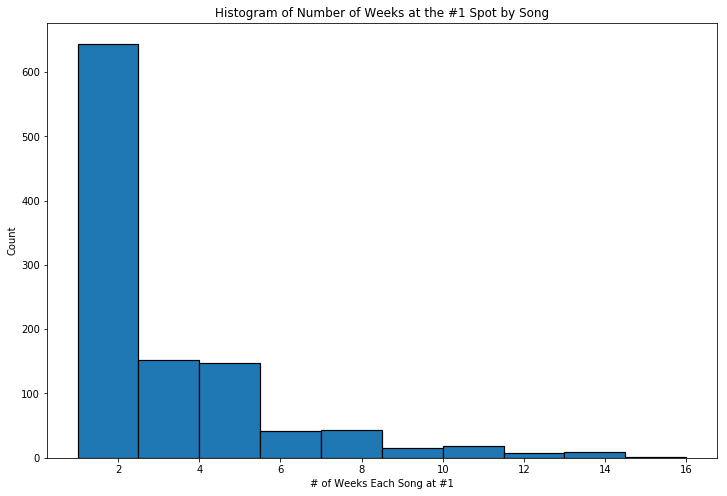

In [12]:
#Descriptive statistics 
print(ChartData["WeeksAtTop"].describe())

#Plot size
plt.rcParams["figure.figsize"] = [12, 8]

#Histogram, labels, etc
plt.hist(ChartData["WeeksAtTop"], edgecolor='black', linewidth=1.2)
plt.ylabel('Count')
plt.xlabel('# of Weeks Each Song at #1')
plt.title('Histogram of Number of Weeks at the #1 Spot by Song')
plt.show()



##### b. Trend in number of weeks a song stays at #1

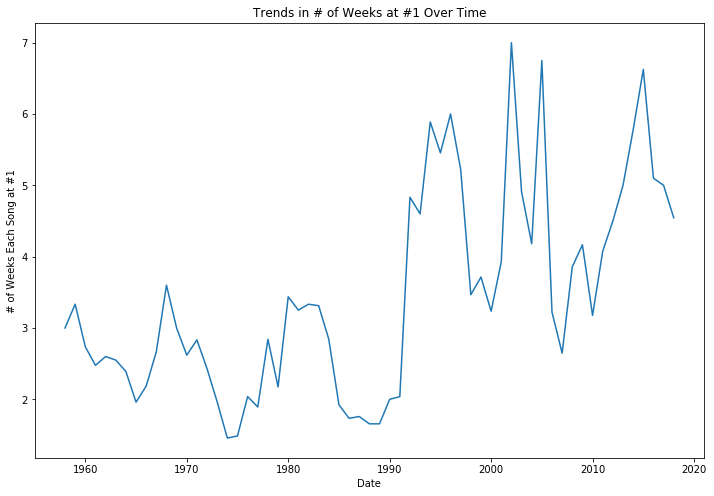

In [13]:
#Line Graph
temp = ChartData
temp["Year"] = temp['DateReachedTop'].map(lambda x: x.year)
temp = temp.groupby("Year").agg('mean')
plt.plot(temp["WeeksAtTop"])
plt.ylabel('# of Weeks Each Song at #1')
plt.xlabel('Date')
plt.title('Trends in # of Weeks at #1 Over Time')
plt.show()

#### ii. Number of Weeks at #1 for each artist
Artists can reach the number 1 spot with multiple songs, in completely different years.  As such, it would be difficult to look at trends over years, since the data would span multiple years.  Also, since each artist has to be at number one at least as long as their song, the number of weeks for artists is going to be higher higher than for each song.  As we can see below, the mean is around 4.45 weeks, however once again we can see that the data is skewed and most artists are clustered closer to 0.  The maximum however is 60, which is extremely high: it's over a whole year.  

       WeeksAtTop          Year
count  570.000000    570.000000
mean     4.452632   3254.601754
std      5.825407   3306.231363
min      1.000000   1958.000000
25%      1.000000   1972.000000
50%      3.000000   1987.000000
75%      5.000000   3931.000000
max     60.000000  37354.000000


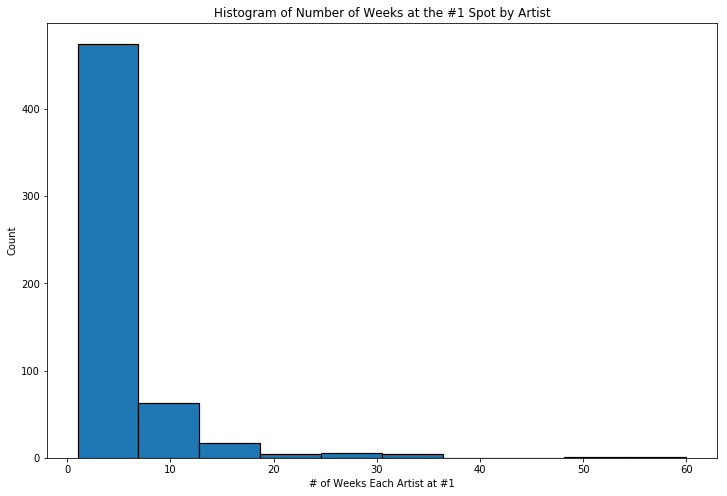

In [14]:
#Set up data
ArtistNumb1Wks = ChartData.groupby(["Artist"]).sum()
ArtistNumb1Wks = ArtistNumb1Wks.sort_values("WeeksAtTop", ascending = False).iloc[1:571,]

#Descriptive statistics
print(ArtistNumb1Wks.describe())

#Histogram, labels, etc
plt.hist(ArtistNumb1Wks["WeeksAtTop"], edgecolor='black', linewidth=1.2)
plt.ylabel('Count')
plt.xlabel('# of Weeks Each Artist at #1')
plt.title('Histogram of Number of Weeks at the #1 Spot by Artist')
plt.show()


### B. Genre
Next we will look at genre, and which ones tend to be at the top the most.  Since there are so many genres, we will classify that if a song is listed under 3 genres, it will count as all 3 so a song might be double counted, but we will only analyze the top 7 genres overall (calculated by how many songs in each genre reached the top).  

#### i. Genre popularity by count of songs

First we will look at the genre popularity by the count of songs listed in that genre that reached number 1 in each year.  We are looking for trends in genre's popularity.  The same data is presented two different ways.  

##### a. Data set-up
We count the number of songs under each genre for a given year, and only take the top 7 most popular genres overall as described above in 2.B.  

In [15]:
#Set up data
GenreDates = pd.merge(SongGenres, ChartData, "right", left_on = "SongName", right_on = "Song")
GenreDates['Year'] = GenreDates['DateReachedTop'].map(lambda x: x.year)
GenreCounts = GenreDates.groupby(["Genre"]).count().sort_values("SongName", ascending = False).iloc[0:7,]
GenreDates = GenreDates.iloc[:,[1,6,7]]
GenreDates = GenreDates.groupby(["Year", "Genre"]).count()
GenreDates.reset_index(inplace = True)
GenreCounts.reset_index(inplace = True)
GenreDates = GenreDates[GenreDates['Genre'].isin(GenreCounts["Genre"])]
GenreDates = GenreDates.set_index(["Year", "Genre"])
UnstackedGD = GenreDates.unstack("Year")
UnstackedGD = UnstackedGD.fillna(0)
UnstackedGD = UnstackedGD.loc[GenreCounts['Genre']]


##### b. Stacked Barplot
Now we make a stacked barplot of the data.  Pop seems to have been the most popular, though this has died down a little in recent years.  Disco had a huge surge in the mid-70's but not much popularity outside of that.  R&B was most popular in the late 90's and 2000's, but that has died down a little as well.  In recent years, the number of songs in these genres has decreased, which could either imply other genres not in the top 7 are gaining popularity, or that songs in the top 7 genres are staying on the charts for longer leading to fewer unique songs in the genre.  Given our findings in 2.A.i.b., the former is more likely, though it could be a combination.  

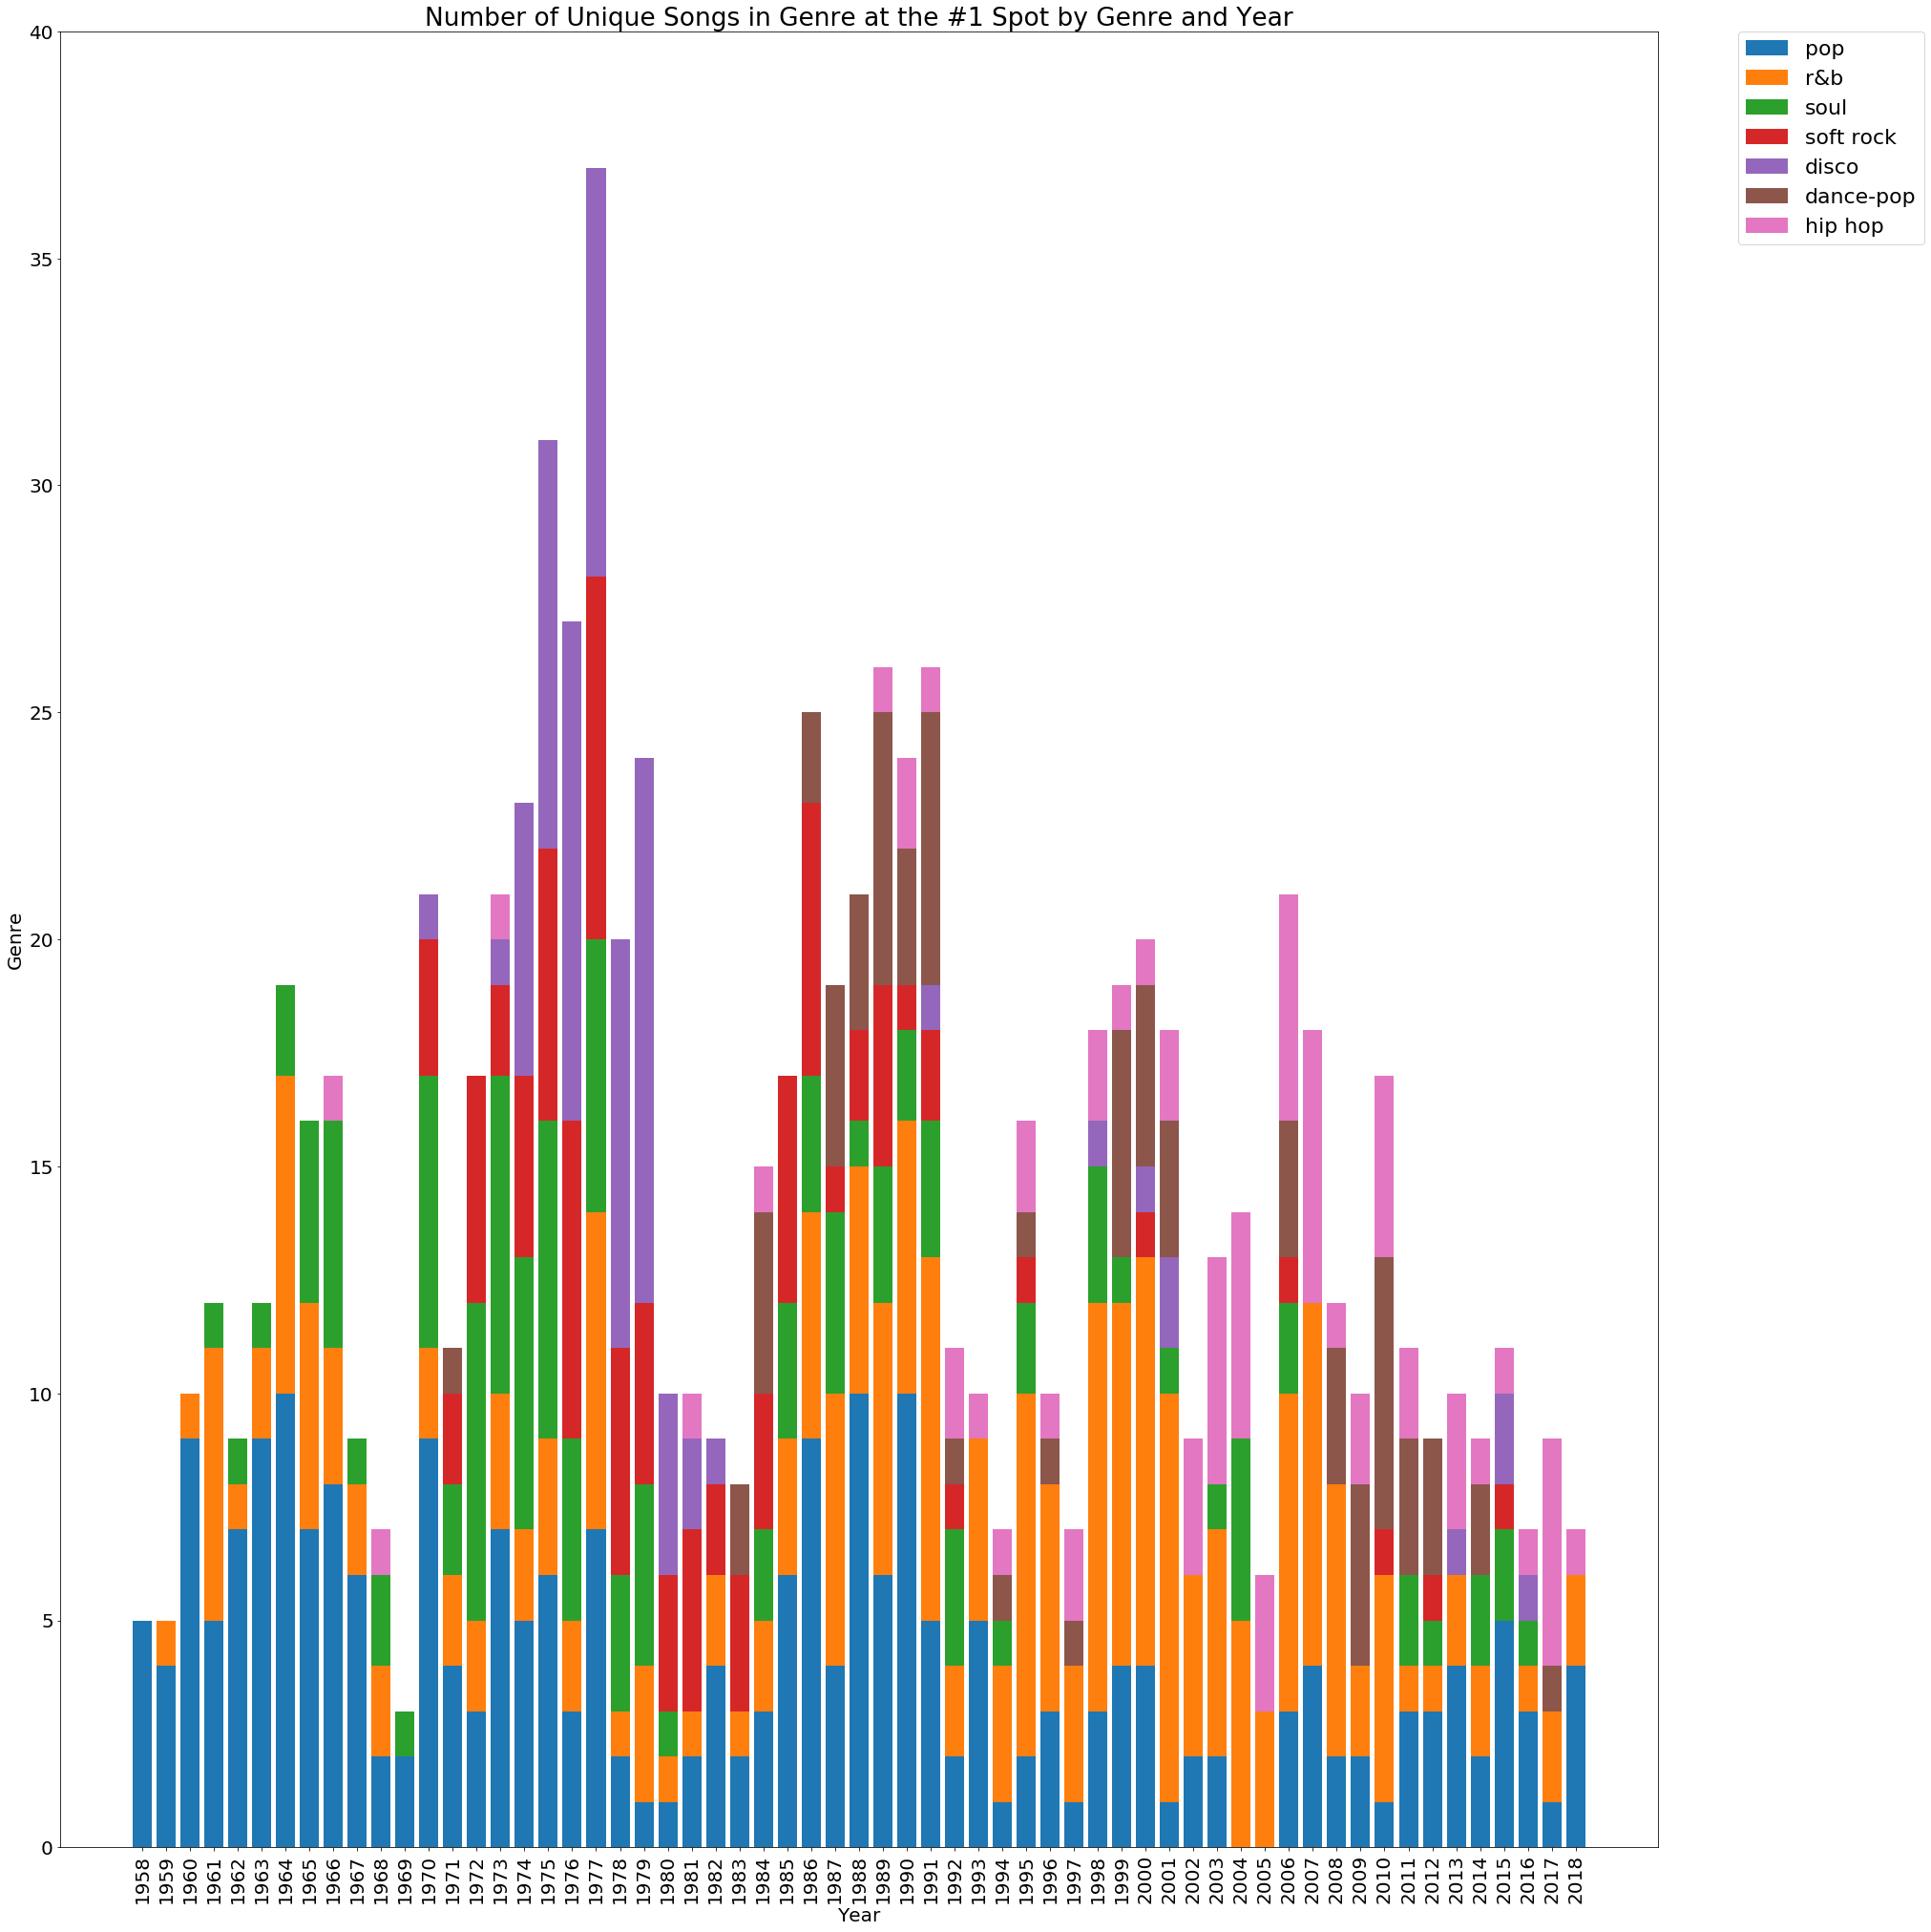

In [16]:
#Set plot size and text parameters
plt.rcParams["figure.figsize"] = [30, 35]
plt.rcParams.update({'font.size': 22})

#Make a list of the years
years = range(1958,2019)

#Plot a stacked bar chart using a forloop
for i in range(0,7):
    if i == 0:
        plt.bar(years, UnstackedGD.iloc[i,0:61])
    else:
        plt.bar(years, UnstackedGD.iloc[i,0:61], bottom=UnstackedGD.iloc[list(range(0,i)),0:61].sum(axis = 0))

#Clean up the chart and make it pretty, adding labels and legend
plt.xticks(years, rotation=90, fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(UnstackedGD.index.values.tolist() , bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Genre', fontsize = 20)
plt.xlabel('Year', fontsize = 20)
plt.title('Number of Unique Songs in Genre at the #1 Spot by Genre and Year')
plt.ylim(0, 40)
plt.show()

##### c. Line Chart
Similar trends as described above in section 2.B.i.b. can be seen in the line chart below.  

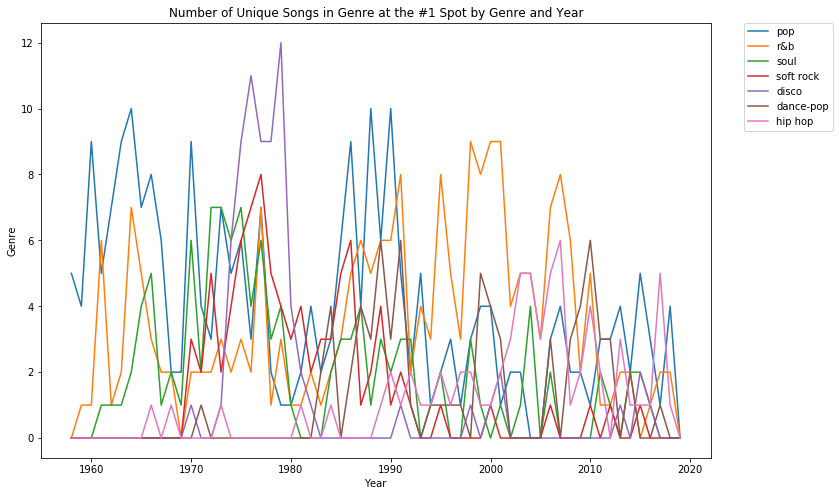

In [17]:
#Set plot size and text parameters
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams.update({'font.size': 10})

#Get data set up
temp = UnstackedGD.transpose().reset_index().set_index("Year").iloc[:,1:8]

#Line chart, labels, etc
plt.plot(temp)
plt.legend(UnstackedGD.index.values.tolist() , bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Genre')
plt.xlabel('Year')
plt.title('Number of Unique Songs in Genre at the #1 Spot by Genre and Year')
plt.show()

#### ii. Genre popularity by number of weeks at Number 1
Now we will look at the genre popularity by the number of weeks any song which was listed in a genre reached number 1 in each year.  We are looking for trends in genre's popularity.  The same data is again presented two different ways.  

##### a. Data set-up
We count the number of weeks any song which was listed in a genre reached number 1 for a given year, and only take the top 7 most popular genres overall as described above in 2.B.  

In [18]:
#Set up data
GenreDates = pd.merge(SongGenres, ChartData, "right", left_on = "SongName", right_on = "Song")
GenreDates['Year'] = GenreDates['DateReachedTop'].map(lambda x: x.year)
GenreCounts = GenreDates.groupby(["Genre"]).count().sort_values("SongName", ascending = False).iloc[0:7,]
GenreDates = GenreDates.iloc[:,[1,6,7]]
GenreDates = GenreDates.groupby(["Year", "Genre"]).sum()
GenreDates.reset_index(inplace = True)
GenreCounts.reset_index(inplace = True)
GenreDates = GenreDates[GenreDates['Genre'].isin(GenreCounts["Genre"])]
GenreDates = GenreDates.set_index(["Year", "Genre"])
UnstackedGD = GenreDates.unstack("Year")
UnstackedGD = UnstackedGD.fillna(0)
UnstackedGD = UnstackedGD.loc[GenreCounts['Genre']]


##### b. Stacked Barplot
The trends are fairly similar to those described in 2.B.i.b.  However, here we can see that the total number of weeks which these genres were in the number one spot did not decrease in recent years, which makes sense given that in recent years, individual songs spent longer in the number one spot, so fewer unique songs made it to the top.  

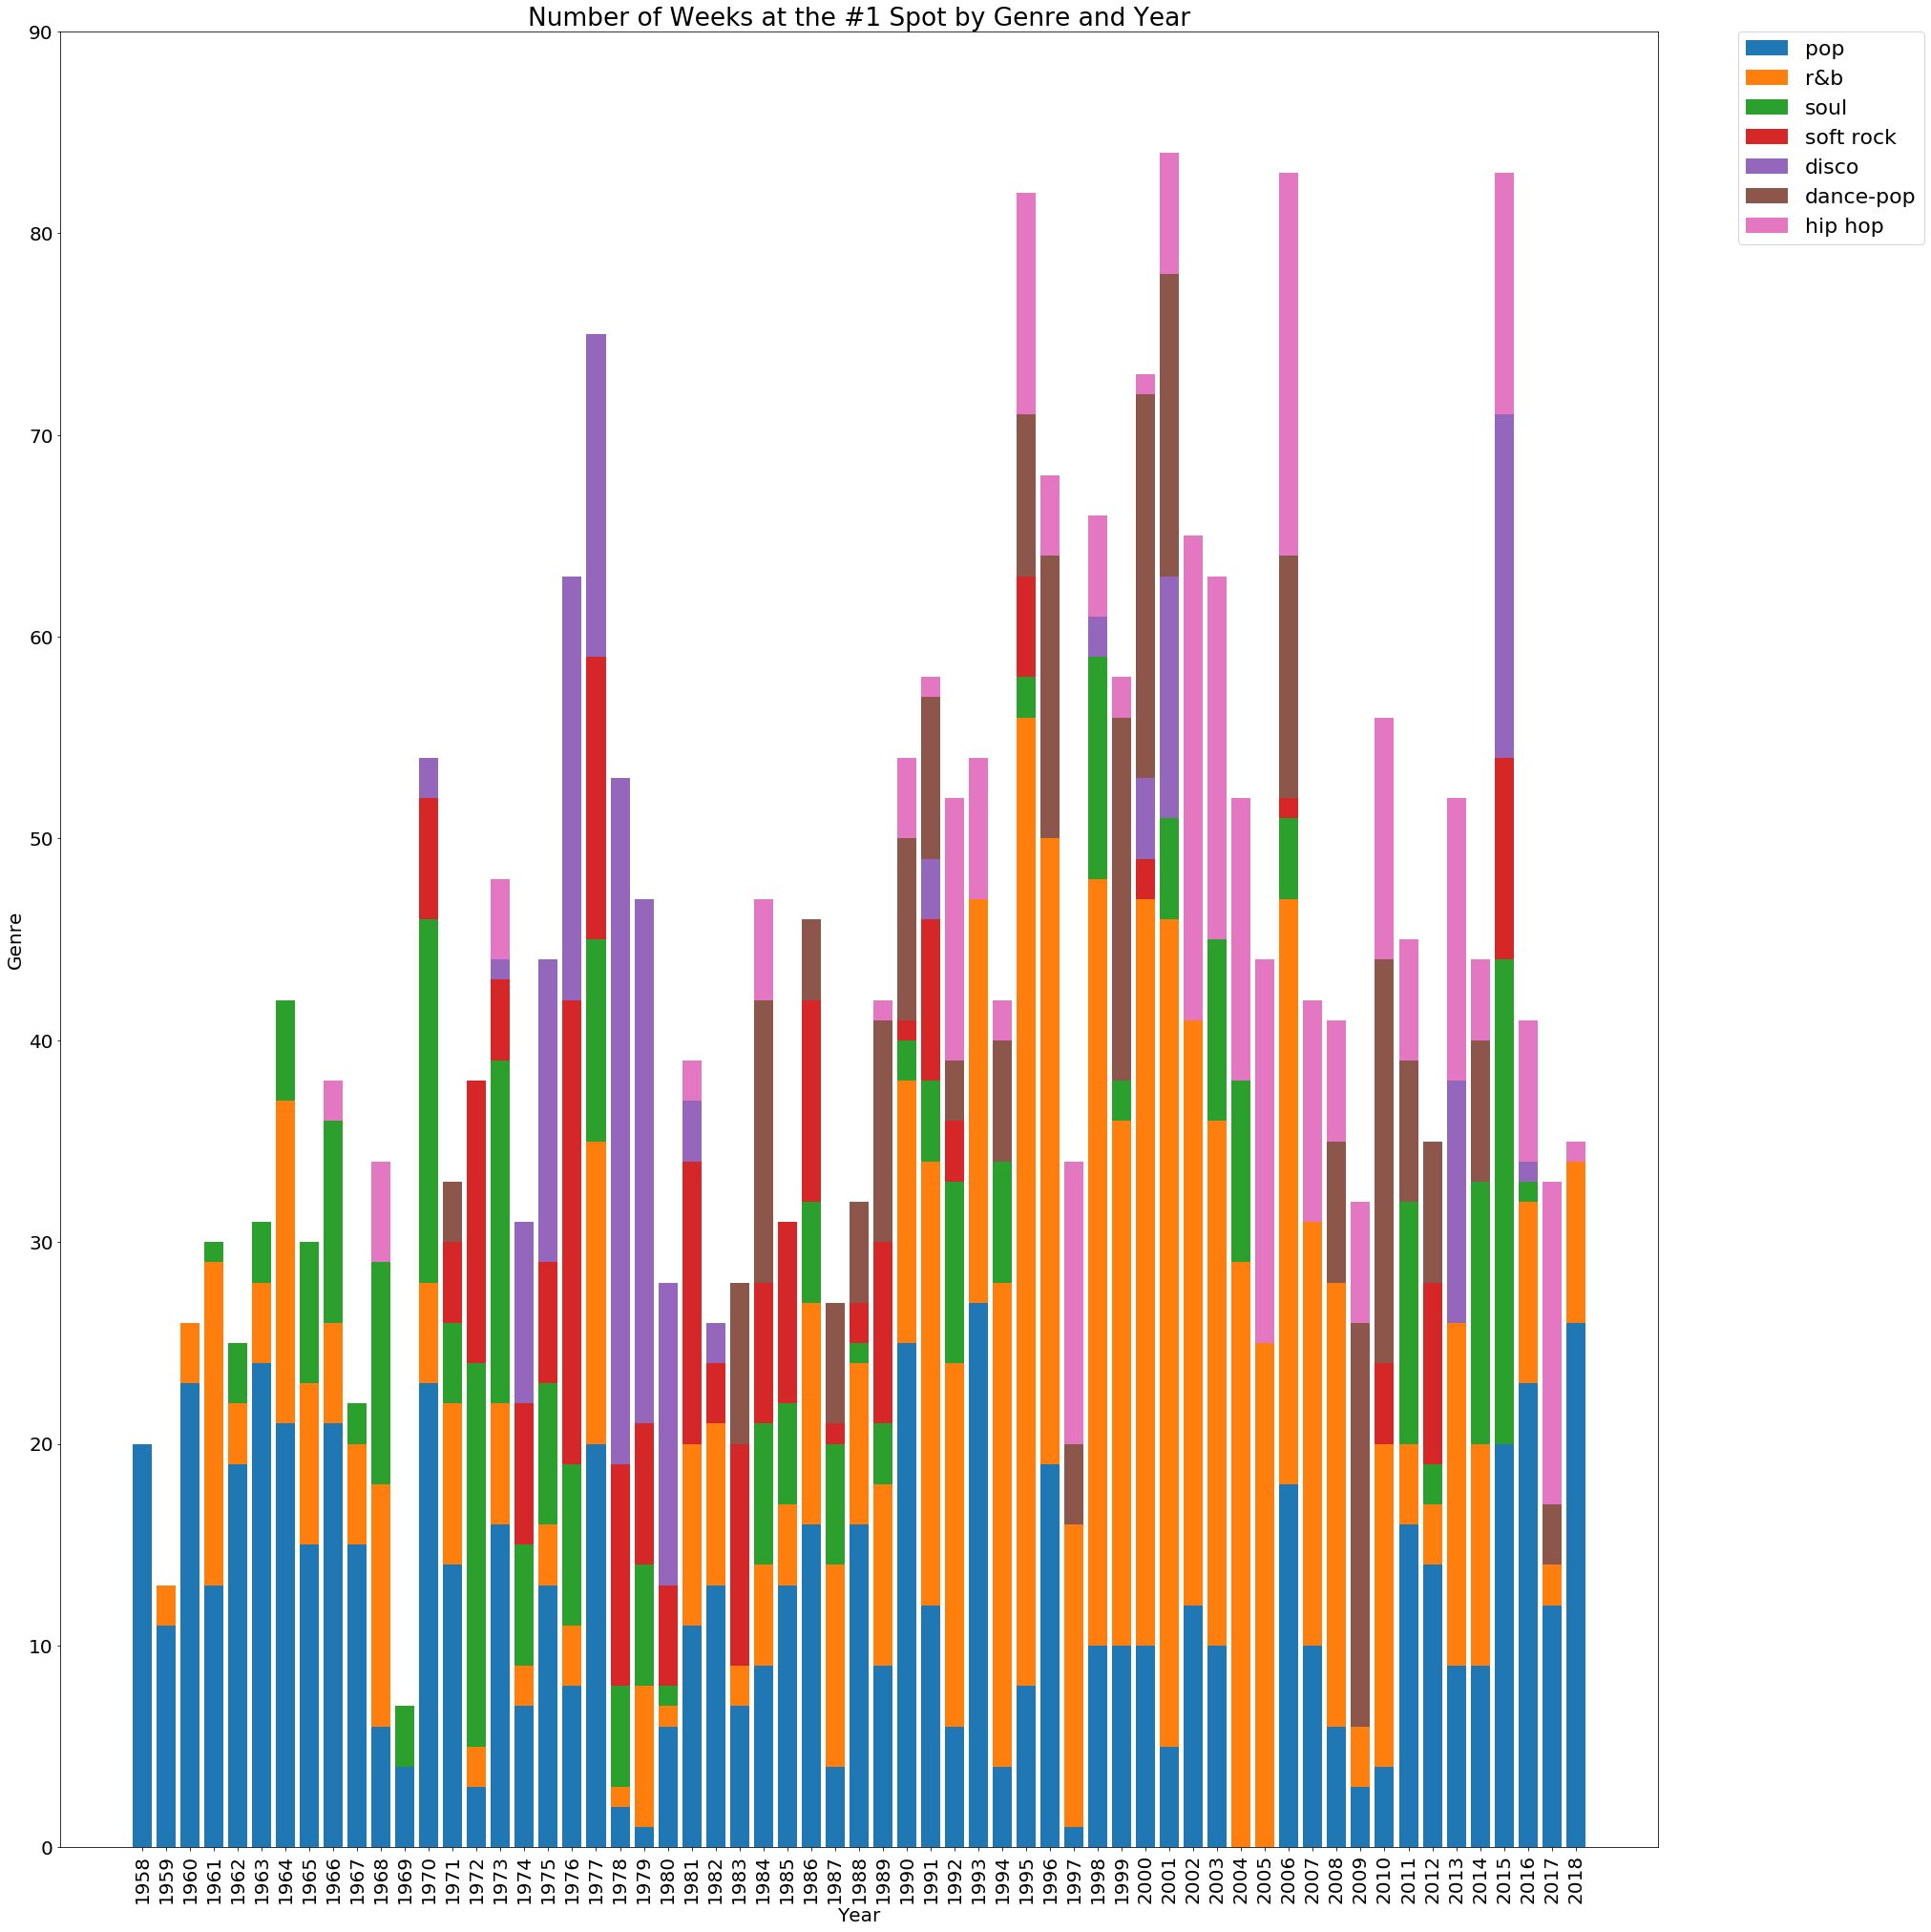

In [19]:
#Set plot size and text parameters
plt.rcParams["figure.figsize"] = [30, 35]
plt.rcParams.update({'font.size': 22})

#Make a list of the years
years = range(1958,2019)

#Plot a stacked bar chart using a forloop
for i in range(0,7):
    if i == 0:
        plt.bar(years, UnstackedGD.iloc[i,0:61])
    else:
        plt.bar(years, UnstackedGD.iloc[i,0:61], bottom=UnstackedGD.iloc[list(range(0,i)),0:61].sum(axis = 0))

#Clean up the chart and make it pretty, adding labels and legend
plt.xticks(years, rotation=90, fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(UnstackedGD.index.values.tolist() , bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Genre', fontsize = 20)
plt.xlabel('Year', fontsize = 20)
plt.title('Number of Weeks at the #1 Spot by Genre and Year')
plt.ylim(0, 90)
plt.show()

##### c. Line Chart
Similar trends as described above in section 2.B.ii.b. can be seen in the line chart below.  

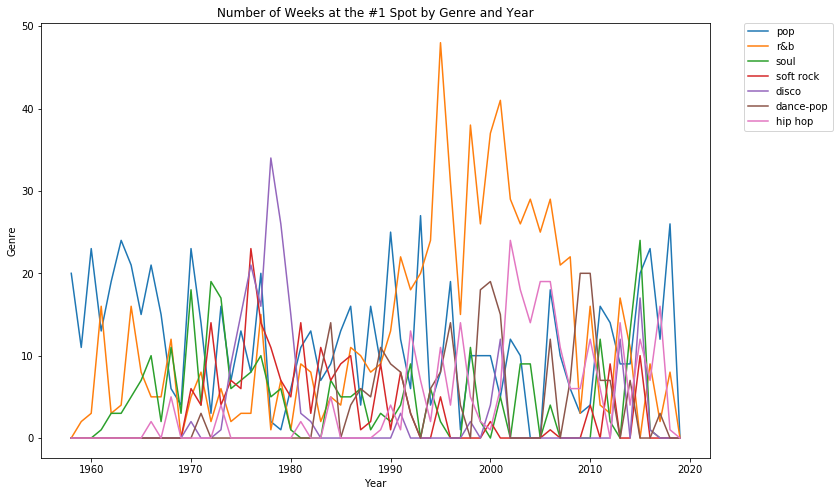

In [20]:
#Set plot size and text parameters
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams.update({'font.size': 10})

#Get data set up
temp = UnstackedGD.transpose().reset_index().set_index("Year").iloc[:,1:8]

#Line chart, labels, etc
plt.plot(temp)
plt.legend(UnstackedGD.index.values.tolist() , bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Genre')
plt.xlabel('Year')
plt.title('Number of Weeks at the #1 Spot by Genre and Year')
plt.show()

### C. Band vs Solo Artists
We are interested in whether bands or solo artists tend to reach the number one spot more often.  

#### i. Pieplot of Number of Bands vs Solo Artists at Number 1
To look at the overall ratio of bands vs solo artists, we made a pie plot.  Approximately 2/3 of the overall number one artists are solo artists.  

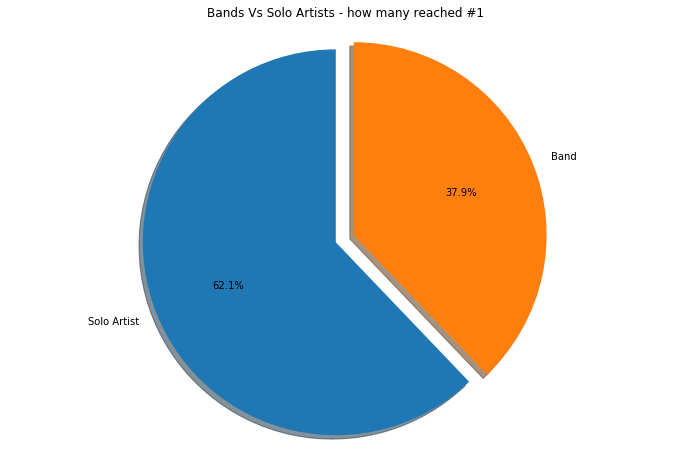

In [26]:
#Set up variables
counts = ArtistInfo.groupby(["Band"]).count()["Artist"]
labels = ["Solo Artist", "Band"]
explode = (0, .1)  

#Makes the pie plot, and adds title
plt.pie(counts, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')  
plt.title('Bands Vs Solo Artists - how many reached #1')
plt.show()

#### ii. Violin plot of Number of Weeks at Number 1 for Bands vs Solo Artists
Even though there are more solo artists on the charts, that does not mean that they stay on top for as long.  Overall in the population, there could just be more solo artists, so even if they are liked evenly, more of the solo artists tend to top the charts.  However, below we can look at the violin plots of number of weeks spent at number 1 for both bands and solo artists.  Solo artists appear to have a distribution on the higher side.  Thus, not only are solo artists more likely to reach the number one spot, but they are more likely to stay up there for longer periods of time.  

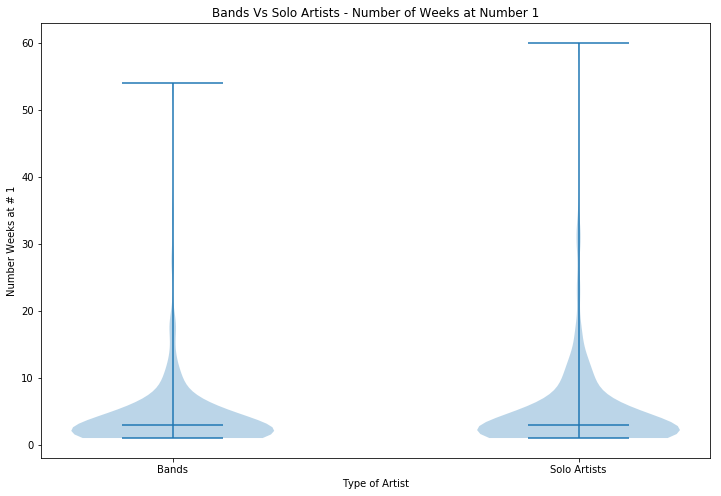

In [27]:
#Sets up the data
ArtistNumb1Wks = pd.merge(ArtistNumb1Wks, ArtistInfo, "left", left_on = "Artist", right_on = "Artist")
temp = ArtistNumb1Wks.iloc[:,[0,1,4]].set_index("Artist")
temp1 = temp[temp["Band_x"] == True] #Bands
temp2 = temp[temp["Band_x"] == False] #Solo Artists

#Creates a violin plot with the medians marked, adds labels, title, etc
plt.violinplot([temp1["WeeksAtTop"], temp2["WeeksAtTop"]],
                   showmeans=False,
                   showmedians=True)
plt.xlabel("Type of Artist")
plt.ylabel("Number Weeks at # 1")
plt.xticks([1,2], ["Bands", "Solo Artists"])
plt.title('Bands Vs Solo Artists - Number of Weeks at Number 1')
plt.show()

### D. Age of Solo Artists
We are also interested in how the age of the artists correlates with them reaching the number one spot, and if this has changed over the years.  Unfortunately, it would be too complicated to include the ages of bands in this analysis, so we will only use the solo artist information.  
#### i. Preparing the Data - Annual Mean Age
First we calculate the mean age per year of the artists who reached number one.  This is the age at the time their song reached number one.  

In [28]:
#Preparing Data
ArtistChart = pd.merge(ChartData, ArtistInfo, "left", left_on = "Artist", right_on = "Artist")
ArtistChart["Age"] = (ArtistChart["DateReachedTop"] - ArtistChart["Birthdate"])
ArtistChart["Age"] = (ArtistChart["Age"].map(lambda x: x.days))/365.25
ArtistChart["Year"] = ArtistChart['DateReachedTop'].map(lambda x: x.year)
AnnualAvgAge = ArtistChart.groupby("Year").agg('mean')


#### ii. Distribution - Summary Statistics and Histogram
Below are the summary statistics and the histogram so we can look at the distribution.  The distribution looks approximately normal, centered around 28.47 which is fairly young.  In addition, there is not much spread: the youngest artist to reach the number one spot was just under 22 years old, and the oldest was just over 38 years old.  Very young, middle-aged, and older solo artists are not able to make it to the number one spot.  

count    62.000000
mean     28.476769
std       3.300837
min      21.723477
25%      26.093808
50%      28.486920
75%      30.568438
max      38.225873
Name: Age, dtype: float64


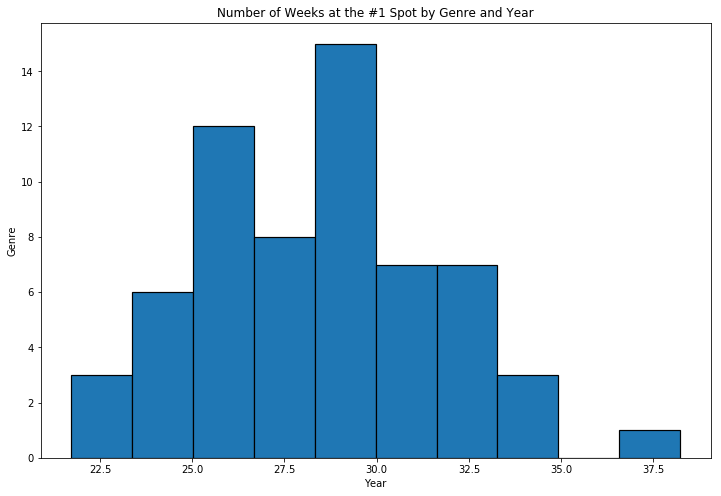

In [29]:
#Summarizing the Data 
print(AnnualAvgAge['Age'].describe())

#Histogram for Distribution
plt.hist(AnnualAvgAge['Age'], edgecolor='black', linewidth=1.2)
plt.ylabel('Genre')
plt.xlabel('Year')
plt.title('Number of Weeks at the #1 Spot by Genre and Year')
plt.show()

#### iii. Trend in Age over time
The trend in average age of solo artists whose songs reach number one on Billboard is shown below.  When Billboard first started, there seems to have been a lot of variation in age.  It leveled off a little and stayed near 30, but around 2000 it fell to around 26 and has ossilated around there since.  Younger artists appear to have been most popular at the start of Billboard, and in recent years.  

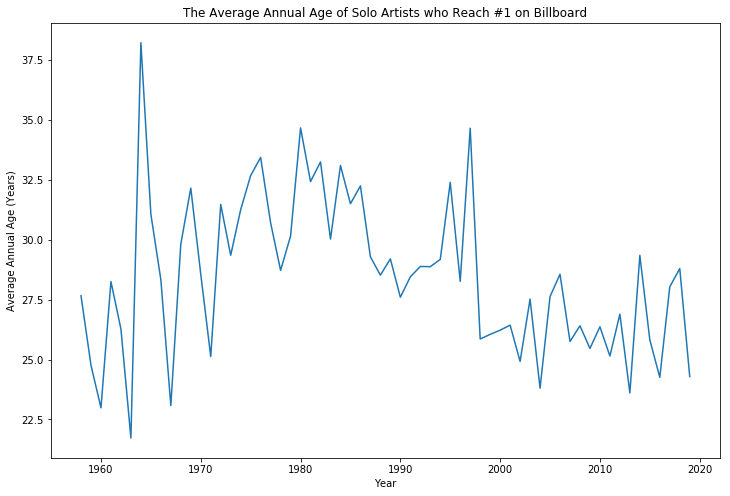

In [30]:
#Linechart of Age over time
plt.plot(AnnualAvgAge['Age'])
plt.ylabel('Average Annual Age (Years)')
plt.xlabel('Year')
plt.title('The Average Annual Age of Solo Artists who Reach #1 on Billboard')
plt.show()

### E. Origin Location of Band / Birth Location of Solo Artist

As we can see below, while there are a few artists who originated from around the world (Japan, South Africa, Australia, Colombia, etc) most seem to have been from the United States and England.  This does make sense because the charts are the top US charts, and the British Invasion (to clarify since the term seems to only be used in the US, the British Invasion refers to the cultural and musical influence of Britain on the US in the 60's) would explain the large number of artists from the UK.  In addition, the US tends to be very insular, so the lack of diversity in locations is probably to be expected.  

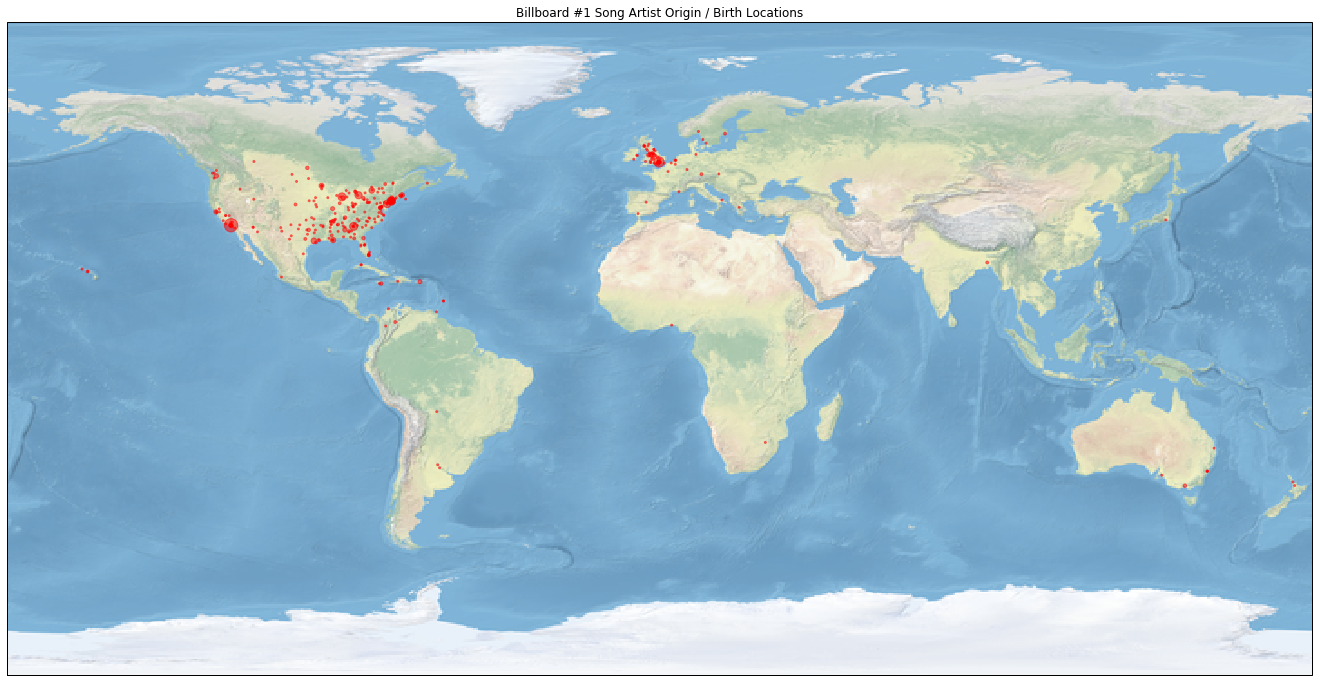

In [31]:
#Sets up Data
NumbArtistsPerLoc = ArtistInfo.iloc[:,[0,5,6]].groupby(["Lat", "Lon"]).count()
NumbArtistsPerLoc.reset_index(inplace = True)

#Sets plot size
plt.rcParams["figure.figsize"] = [30, 12]

#Gets the background
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

#Adds the points with size representing how many in that spot, etc, adds title
plt.scatter(NumbArtistsPerLoc.iloc[:,1], NumbArtistsPerLoc.iloc[:,0], s=NumbArtistsPerLoc.iloc[:,2]*4, alpha=0.5, c = "r")
plt.title('Billboard #1 Song Artist Origin / Birth Locations')
plt.show()



## 3. Modeling
We will attempt two modeling techniques: one is mapping the relationships between genres where they are both genres of the same song, and the other will be linear regression modeling of how many weeks a song will stay at the number one spot.  

### A. Mapping Genre connections between songs
Mapping the genres is shown below.  We limit it to genres that occur more than once.  Every genre is connected to at least one other, and most share many connections.  

/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


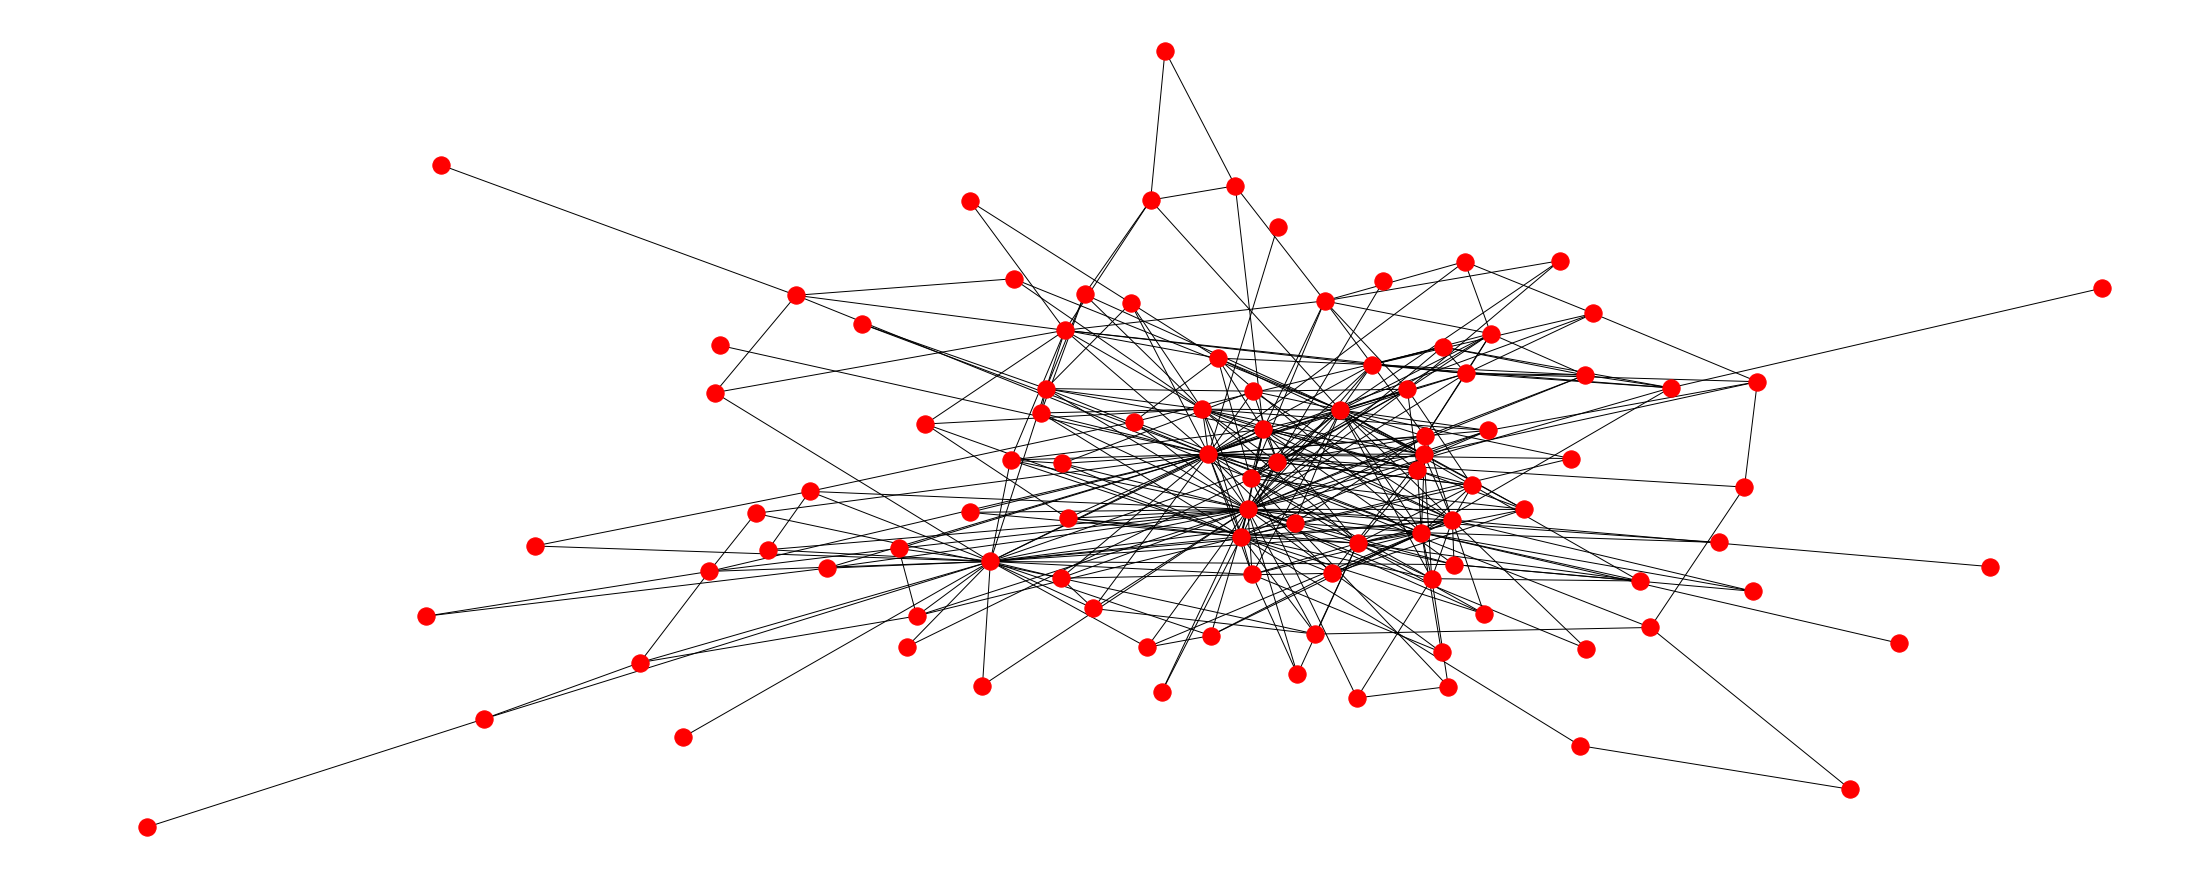

In [32]:
#Sets up the data 
GenreCount = SongGenres.groupby("Genre").count()
GenreCount = GenreCount[GenreCount["SongName"] > 1]
GenreCount["GenreID"] = range(1,100)
Temp = SongGenres[SongGenres["Genre"].isin(GenreCount.index.values.tolist())]
GenreCount = GenreCount.reset_index()
Temp = pd.merge(Temp, GenreCount, "left", left_on = "Genre", right_on = "Genre")
data_to_merge = Temp.merge(
    Temp[["GenreID", "SongName_x"]].rename(columns={"GenreID":"GenreID"+"_2"}), 
    on="SongName_x")
d = data_to_merge[~(data_to_merge["GenreID"]==data_to_merge["GenreID"+"_2"])].dropna()[["GenreID", "GenreID"+"_2", "SongName_x"]]
d.drop(d.loc[d["GenreID"+"_2"]<d["GenreID"]].index.tolist(), inplace=True)
d = d.groupby(["GenreID", "GenreID_2"]).count().reset_index()

#Creates the graph
G = nx.from_pandas_edgelist(df=d, source="GenreID", target="GenreID"+'_2', edge_attr="SongName_x")
nx.draw(G)


### B. Linear Regression modeling of how many weeks a song will stay at number 1
We will attemp to model the number of weeks which a song spends on the number one chart.  The variables which we will use are: 
-  If the artist is a solo artist or not (binary variable)
-  The age of the artist * If the artist is a solo artist 
-  The age of the artist squared * If the artist is a solo artist
-  The year the song occurred in
We need to multiply the ages by the binary solo variable so that age only affects the solo artists.  Otherwise bands would be eliminated from the regression.  We will  do age squared in case that has a parabolic relationship.  

Unfortunately the data is not normally distributed, and a log transformation does not fix the problem either, so this is a problem we will have to be aware of when interpreting the results.  

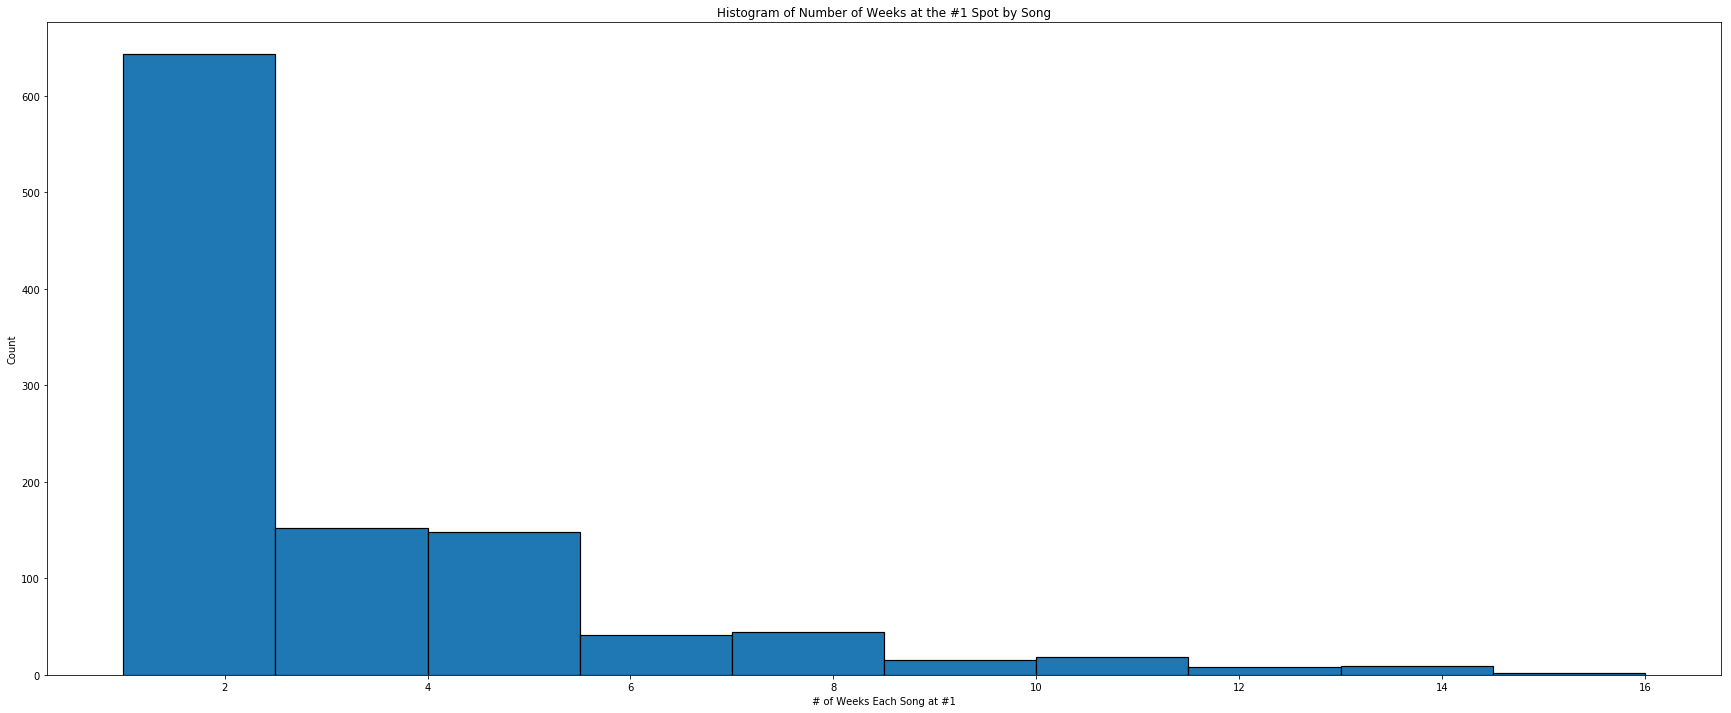

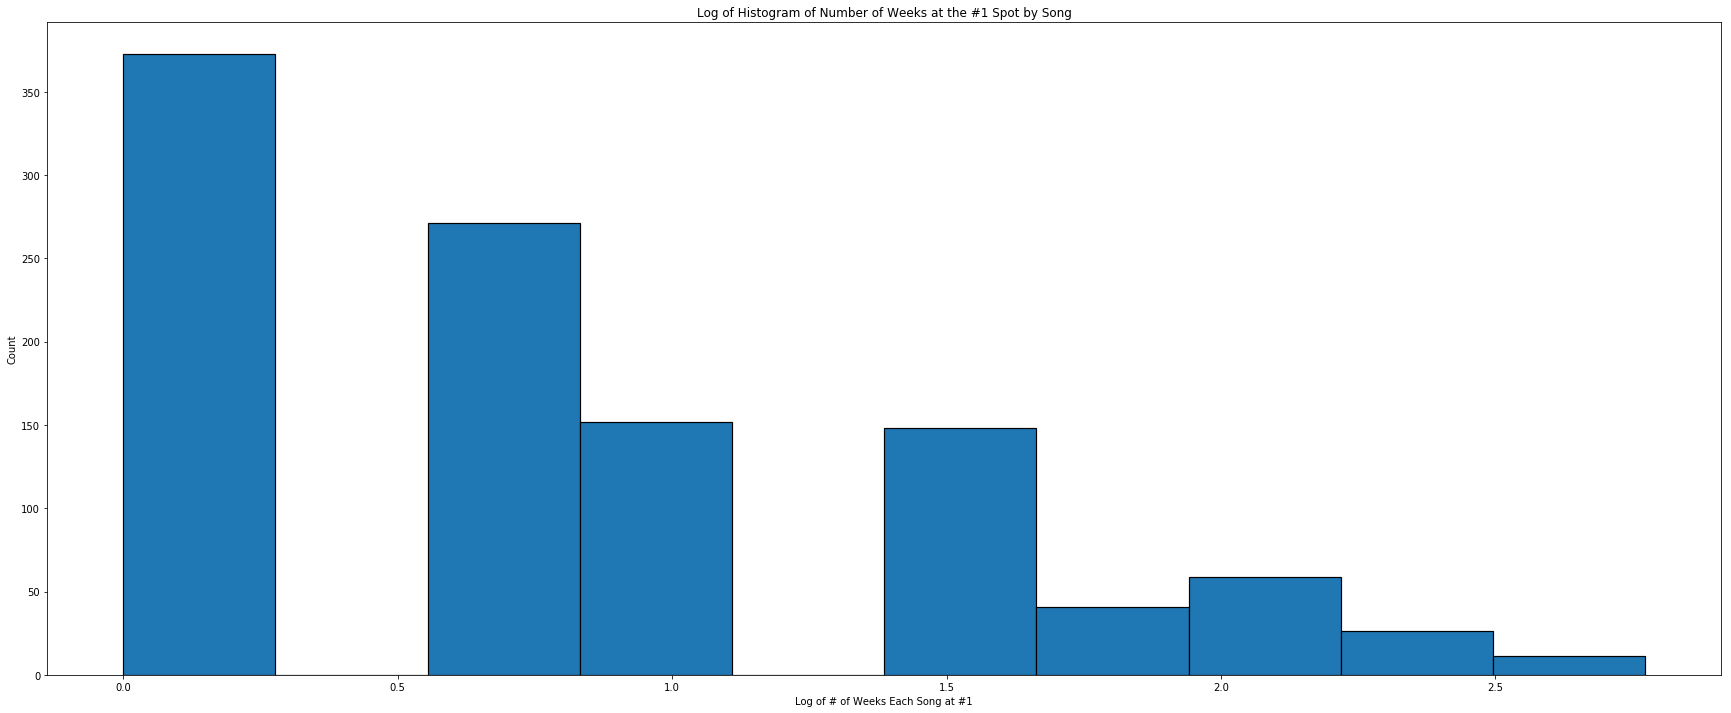

In [33]:
#Histogram
plt.hist(ChartData["WeeksAtTop"], edgecolor='black', linewidth=1.2)
plt.ylabel('Count')
plt.xlabel('# of Weeks Each Song at #1')
plt.title('Histogram of Number of Weeks at the #1 Spot by Song')
plt.show()

#Histogram of log
plt.hist(np.log(ChartData["WeeksAtTop"]), edgecolor='black', linewidth=1.2)
plt.ylabel('Count')
plt.xlabel('Log of # of Weeks Each Song at #1')
plt.title('Log of Histogram of Number of Weeks at the #1 Spot by Song')
plt.show()

In [45]:
#Sets up the data
Temp = ArtistChart.iloc[0:1083,[4,7,12,5]].dropna(thresh = 3)
Temp = Temp.fillna(0) 
Temp["Solo"] = (Temp["Band"] == False)
Temp["AgeSq"] = Temp["Age"]**2 

#Runs the model and shows the results
results = smf.ols('WeeksAtTop ~ Solo + Age + AgeSq + Year', data=Temp).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             WeeksAtTop   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     13.60
Date:                Mon, 14 Jan 2019   Prob (F-statistic):           8.98e-11
Time:                        09:47:47   Log-Likelihood:                -2032.1
No. Observations:                 922   AIC:                             4074.
Df Residuals:                     917   BIC:                             4098.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -62.3601      9.796     -6.366   

While some variables appear to be statistically significant because of their low p-value, the overall model only has an R-squared value of 0.060 so it is a pretty bad model.  Some of the variables have the expected signs: more solo artists have spent more weeks at number 1 so that should be positive and the weeks spent at number 1 increased as the years went by so this should be positive.  However, age implies that the minimum number of weeks spent at the top occurs around 36, and that the number goes up as you get both older and younger.  It should be a maximum around 28, and decrease as you get older and younger.  

## 4. Conclusion

We have now looked at a number of different variables connected to the songs on the list of Billboard's weekly number songs including the number of weeks a song was on at the top spot, the genres of the song, whether it was made by a band or a solo artist, the age of the artist, and the location where the artist is from.  In addition, we looked at how these have all changed over time.  By analyzing the qualities of the songs which topped the charts, it gives us insights into not only what types of future songs might be successful, but, theoretically, by analyzing our data it should help us to build better models.  While the models attempted here were not the most successful, it can definitely help in other situations.  However, possibly more important, by analyzing data on something so pervasive in our world, we can learn a lot about history and society such as the immense but fleeting popularity of disco, or the insulation of the United States.  Our lives are so intertwined with music, that it provides a powerful lens to analyze society with, and data analysis is simple a tool that lets us accomplish this.  